In [137]:
import os

from copy import deepcopy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix, precision_recall_curve
)
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms

# 加载数据、填补NaN、数值处理、归一化

In [142]:
FEATURE_COLUMNS = [
     'B', 'COM_RAT', 'Cyclic', 'D',
    'Dcy*', 'DIT', 'DPT*', 'E', 'Inner', 'LCOM', 'Level', 'LOC', 'N',
    'NCLOC', 'NOAC', 'NOC', 'NOIC', 'OCmax', 'PDcy', 'PDpt', 'STAT', 'SUB',
    'TCOM_RAT', 'V', 'WMC', 'CBO', 'CLOC', 'Command', 'CONS', 'CSA', 'CSO',
    'CSOA', 'Dcy', 'DPT', 'INNER', 'jf', 'JLOC', 'Jm', 'Level*', 'MPC', 'n',
    'NAAC', 'NAIC', 'NOOC', 'NTP', 'OCavg', 'OPavg', 'OSavg', 'OSmax',
    'Query', 'RFC', 'TODO'
]
LABEL_COLUMN = "1适合LLM"

def load_data(data_path, feature_cols=FEATURE_COLUMNS, label_col=LABEL_COLUMN):
    df = pd.read_excel(data_path)
    df = df.fillna(-1)  # Fill NaN values with -1, as in your original code
    x = df[feature_cols].to_numpy()
    y = df[label_col].to_numpy()
    return x, y

train_x, train_y = load_data('train.xlsx')
test_x, test_y = load_data('test.xlsx')
# 
# scaler = StandardScaler()
# scaler.fit(train_x)
# print(scaler.mean_)
# print(scaler.var_)
# 
# train_x = scaler.transform(train_x)

# （可选）降维，以下两种降维方法任选一种

## （可选）计算相关性矩阵并聚类，根据聚类结果选择特征
max_d 决定聚类数量，数值越大类越少，降维后特征越少

C:\Users\17958\AppData\Local\Temp\ipykernel_3080\3811934836.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(distance_matrix, method='ward')


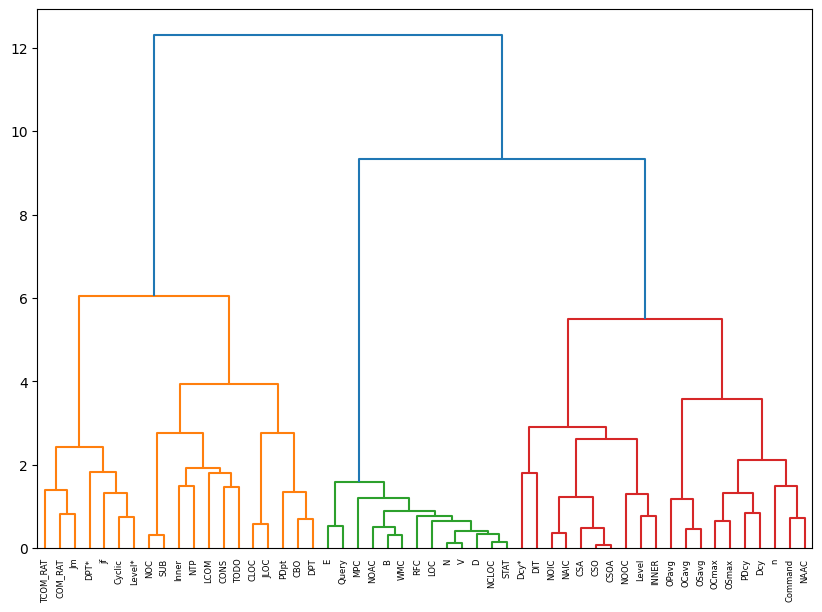

[17  1  4 18 20 21  6 16  8 12 24 18 18 18 17  7 22 28 29 15 18  7  3 18
 17 14 13 31 10 23 23 23 30 14 24  5 13  2  4 19 32 31 22 25  9 26 27 26
 28 16 18 11]
32 [1, 37, 22, 2, 35, 6, 15, 8, 44, 28, 51, 9, 26, 25, 19, 7, 0, 3, 39, 4, 5, 16, 29, 10, 43, 45, 46, 17, 18, 32, 27, 40]
['COM_RAT', 'Jm', 'TCOM_RAT', 'Cyclic', 'jf', 'DPT*', 'NOC', 'Inner', 'NTP', 'CONS', 'TODO', 'LCOM', 'CLOC', 'CBO', 'PDpt', 'E', 'B', 'D', 'MPC', 'Dcy*', 'DIT', 'NOIC', 'CSA', 'Level', 'NOOC', 'OCavg', 'OPavg', 'OCmax', 'PDcy', 'Dcy', 'Command', 'n']


In [143]:
df_train = pd.read_excel('train.xlsx')
df_train = df_train.fillna(-1)  # 保持 NaN 填充为 -1 的逻辑
corr = df_train[FEATURE_COLUMNS].corr()
distance_matrix = 1 - corr
Z = sch.linkage(distance_matrix, method='ward')
plt.figure(figsize=(10, 7))
sch.dendrogram(Z, labels=corr.columns)
plt.show()
max_d = 0.8
clusters = fcluster(Z, max_d, criterion='distance')
print(clusters)

_ids_list = []
_names_list = []
for _idx in range(max(clusters)):
    _ids = np.where(clusters == _idx + 1)[0][0]
    _ids_list.append(_ids)
    _names_list.append(corr.columns[_ids])
print(len(_ids_list), _ids_list)
print(_names_list)

# 应用选择的特征到训练集和测试集
train_x = train_x[:, _ids_list]
test_x = test_x[:, _ids_list]

## （可选）直接PCA降维
n_components 表示降维后特征维度

In [115]:
pca = PCA(n_components=40)
train_x = pca.fit_transform(train_x)
print(train_x.shape)

ValueError: n_components=40 must be between 0 and min(n_samples, n_features)=33 with svd_solver='full'

# 6:2:2 拆分数据集

In [144]:
train_x, val_x, train_y, val_y = train_test_split(
    train_x, train_y, test_size=0.2, random_state=42)
print(train_x.shape, val_x.shape, test_x.shape)
# import pandas as pd
# pd.DataFrame(test_x).to_csv(r'C:\Users\17958\Desktop\test_x.csv', index=False)
# pd.DataFrame(test_y).to_csv(r'C:\Users\17958\Desktop\test_y.csv', index=False)

(658, 32) (165, 32) (210, 32)


# 定义数据集类和深度模型类

In [145]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = torch.FloatTensor(data)
        self.labels = torch.FloatTensor(labels)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data, labels = self.data[idx], self.labels[idx]
        if self.transform:
            data = self.transform(data)
        return data, labels

class Block1D(nn.Module):
    def __init__(self, in_channels):
        super(Block1D, self).__init__()
        self.layer1 = nn.Linear(in_channels, in_channels)
        self.norm1 = nn.BatchNorm1d(in_channels)
        self.layer2 = nn.Linear(in_channels, in_channels)
        self.norm2 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
    def forward(self, x):
        identity = x
        x = self.layer1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.norm2(x)
        x = x + identity
        x = self.relu(x)
        return x

class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.block1 = Block1D(128)
        self.layer3 = nn.Linear(128, 64)
        self.block2 = Block1D(64)
        self.output = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.block1(x)
        x = self.layer3(x)
        x = self.relu(x)
        x = self.block2(x)
        x = self.output(x)
        return x

# 训练设置

In [146]:
batch_size = 32
class AddNoise:
    def __init__(self, p=0.5, noise_scale=0.05):
        self.p = p
        self.noise_scale = noise_scale
    def __call__(self, x):
        if torch.rand(1).item() < self.p:
            x = x + torch.randn_like(x) * self.noise_scale
        return x

class RandomZero:
    def __init__(self, feat_drop_prob=0.2):
        self.feat_drop_prob = feat_drop_prob
    def __call__(self, x):
        mask = torch.rand_like(x) > self.feat_drop_prob
        x *= mask.float()
        return x
        
transform = transforms.Compose([
    # AddNoise(0.8, 0.02),
    # RandomZero(0.05)
])
train_dataset = CustomDataset(train_x, train_y, transform)
val_dataset = CustomDataset(val_x, val_y)
test_dataset = CustomDataset(test_x, test_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

num_features = len(train_dataset[0][0])
model = BinaryClassifier(input_dim=num_features)
criterion = nn.BCEWithLogitsLoss()  # 内置Sigmoid + 交叉熵
optimizer = optim.AdamW(
    model.parameters(), lr=1e-3, weight_decay=1e-4)

num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BinaryClassifier(
  (layer1): Linear(in_features=32, out_features=128, bias=True)
  (block1): Block1D(
    (layer1): Linear(in_features=128, out_features=128, bias=True)
    (norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer2): Linear(in_features=128, out_features=128, bias=True)
    (norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (block2): Block1D(
    (layer1): Linear(in_features=64, out_features=64, bias=True)
    (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer2): Linear(in_features=64, out_features=64, bias=True)
    (norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
)

# 开始训练

In [147]:
bast_acc = 0.0
best_epoch = 0
best_state_dict = None
last_state_dict = None
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        mask = torch.rand_like(inputs) < 0.3
        _idx = torch.randperm(len(inputs))
        _id_mask = torch.rand_like(_idx.float()) > 1.0
        _idx[_id_mask] = torch.arange(len(inputs))[_id_mask]
        inputs[mask] = inputs[_idx][mask]
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)

        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    # 计算训练损失
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = correct / total
    
    # 验证阶段
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = correct / total
    if bast_acc < test_acc:
        best_state_dict = deepcopy(model.state_dict())
        bast_acc = test_acc
        best_epoch = epoch+1
    last_state_dict = deepcopy(model.state_dict())
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Loss: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
print(f'Epoch: {best_epoch} | best acc: {bast_acc:.4f}')

Epoch 1/100
Train Loss: 0.6287 | Train Loss: 0.6368 | Test Loss: 0.4773 | Test Acc: 0.6788
Epoch 2/100
Train Loss: 0.5534 | Train Loss: 0.7158 | Test Loss: 0.4398 | Test Acc: 0.6727
Epoch 3/100
Train Loss: 0.5385 | Train Loss: 0.7188 | Test Loss: 0.4419 | Test Acc: 0.6667
Epoch 4/100
Train Loss: 0.5714 | Train Loss: 0.7052 | Test Loss: 0.4244 | Test Acc: 0.7091
Epoch 5/100
Train Loss: 0.5470 | Train Loss: 0.7356 | Test Loss: 0.4417 | Test Acc: 0.6848
Epoch 6/100
Train Loss: 0.5311 | Train Loss: 0.7401 | Test Loss: 0.4049 | Test Acc: 0.7576
Epoch 7/100
Train Loss: 0.5346 | Train Loss: 0.7234 | Test Loss: 0.4473 | Test Acc: 0.7091
Epoch 8/100
Train Loss: 0.5265 | Train Loss: 0.7416 | Test Loss: 0.4356 | Test Acc: 0.7273
Epoch 9/100
Train Loss: 0.5307 | Train Loss: 0.7280 | Test Loss: 0.4354 | Test Acc: 0.6970
Epoch 10/100
Train Loss: 0.5366 | Train Loss: 0.7097 | Test Loss: 0.4472 | Test Acc: 0.6788
Epoch 11/100
Train Loss: 0.5220 | Train Loss: 0.7416 | Test Loss: 0.4666 | Test Acc: 0.68

# 测试

In [148]:
model.load_state_dict(best_state_dict) # best_state_dict last_state_dict
model.eval()
test_loss = 0.0
correct = 0
total = 0
y_target = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        y_target.extend(labels.view(-1).cpu().numpy())
        outputs = model(inputs)
        y_pred.extend(torch.nn.functional.sigmoid(outputs).view(-1).cpu().numpy())
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        
        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total += labels.size(0)

y_target = np.array(y_target)
y_pred = np.array(y_pred)
test_loss = test_loss / len(test_loader.dataset)
test_acc = correct / total
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Test Loss: 0.4990 | Test Acc: 0.7143


# 结果

In [149]:
metrics = {
    '准确率': accuracy_score(y_target, y_pred > 0.5),
    '精确率': precision_score(y_target, y_pred > 0.5),
    '召回率': recall_score(y_target, y_pred > 0.5),
    'F1分数': f1_score(y_target, y_pred > 0.5),
    'AUC': roc_auc_score(y_target, y_pred)
}
print(metrics)

{'准确率': 0.7142857142857143, '精确率': 0.5434782608695652, '召回率': 0.390625, 'F1分数': 0.45454545454545453, 'AUC': 0.7806078767123288}


In [150]:
confusion_matrix(y_target, y_pred > 0.5)

array([[125,  21],
       [ 39,  25]], dtype=int64)

In [151]:
print(
    classification_report(y_target, y_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81       146
         1.0       0.54      0.39      0.45        64

    accuracy                           0.71       210
   macro avg       0.65      0.62      0.63       210
weighted avg       0.70      0.71      0.70       210

